# Notebook: comparison tests
    by Ulrich Voggenberger
    16.11.2021


In [4]:
# System information
import numpy as np
import matplotlib.pyplot as plt
import os, sys, glob, time
import pandas as pd
import xarray
import h5py
import pickle
import netCDF4 as nc
import multiprocessing
from functools import partial
import datetime
from scipy import stats
import cdsapi
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
plt.rcParams['figure.figsize'] = [12, 8]


In [25]:
def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref).values

In [34]:
def calc_anomaly(data, date, mean_preset = None):
    data_c = data.copy()
    if mean_preset == None:
        mean = [0]*12
        count = [0]*12
        for i in range(len(data_c)):
            if not np.isnan(data_c[i]):
                for j in range(1, 13):
                    if date[i].month == j:
                        mean[j-1] += data_c[i]
                        count[j-1] += 1
                        break
        for j in range(1,13):
            try:
                mean[j-1] = mean[j-1]/count[j-1]
            except:
                mean[j-1] = np.nan
    else:
        mean = mean_preset
    for i in range(len(data_c)):
        if not np.isnan(data_c[i]):
            for j in range(1,13):
                if date[i].month == j:
                    data_c[i] -= mean[j-1]
    return data_c, mean

In [8]:
def request(r_dict, dataset, data_dir = './comparison_dir', rm_files = False):
    try:
        os.makedirs(data_dir)
    except:
        pass

    tt = time.time()
    c = cdsapi.Client()
    r = c.retrieve(dataset,r_dict)
    tr = time.time()
    r.download(target='download.zip')
    tdl = time.time()
    z = zipfile.ZipFile('download.zip')
    z.extractall(path = data_dir+'/')
    z.close()
    tuz = time.time()

    print('request: ', tr - tt, ' s')
    print('download: ', tdl - tr, ' s')
    print('over all : ', tdl - tt, ' s \n-')
    print('unzip: ', tuz - tdl, ' s \n-')
    
    print('zip size: ', os.path.getsize('download.zip')/1000000., ' MB')
    filesize_token = 0
    for filename in os.listdir(data_dir):
        file_path = os.path.join(data_dir, filename)
        filesize_token += os.path.getsize('download.zip')
        if rm_files:
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))
    print('file size: ', filesize_token/1000000., ' MB')


 ## 2) calculation of monthly temperature anomalies (from 1978 to 2020, at all mandatory pressure levels from 850 to 10 hPa)

### CDS request

In [15]:
request({'variable': ["temperature"],
         'date': ['19780101','20201231'],
         'statid': '11035',
         'cached': 0,
        }, 
        'insitu-comprehensive-upper-air-observation-network',
        data_dir = './comparison_dir/1',
        rm_files = True)

2021-11-17 10:35:59,345 INFO Welcome to the CDS
2021-11-17 10:35:59,347 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-11-17 10:35:59,406 INFO Request is queued
2021-11-17 10:36:00,451 INFO Request is running
2021-11-17 10:36:12,805 INFO Request is completed
2021-11-17 10:36:12,806 INFO Downloading http://download-0001-sisdev.copernicus-climate.eu/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1637141768.9911814-22869-6-ff101eac-8225-4d3b-8ab8-bdb7f0b4a2bb.zip to download.zip (59.5M)
2021-11-17 10:36:30,007 INFO Download rate 3.5M/s                               


request:  13.495199918746948  s
download:  17.202439308166504  s
over all :  30.697639226913452  s 
-
unzip:  0.09434008598327637  s 
-
zip size:  62.341331  MB
file size:  62.341331  MB


In [16]:
request({'variable': ["temperature"],
         'date': ['19780101','20201231'],
         'statid': '11035',
         'format': 'csv',
         'cached': 0,
        }, 
        'insitu-comprehensive-upper-air-observation-network',
        data_dir = './comparison_dir/1',
        rm_files = True)

2021-11-17 10:36:30,187 INFO Welcome to the CDS
2021-11-17 10:36:30,188 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-11-17 10:36:30,250 INFO Request is queued
2021-11-17 10:36:31,290 INFO Request is running
2021-11-17 10:37:19,867 INFO Request is completed
2021-11-17 10:37:19,868 INFO Downloading http://download-0001-sisdev.copernicus-climate.eu/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1637141825.6405373-26854-1-0b4c7e65-9489-43be-894a-fdcd2367faff.zip to download.zip (33.2M)
2021-11-17 10:37:23,944 INFO Download rate 8.2M/s                               


request:  49.712313652038574  s
download:  4.077640771865845  s
over all :  53.78995442390442  s 
-
unzip:  0.059554100036621094  s 
-
zip size:  34.85825  MB
file size:  34.85825  MB


In [17]:
request({'variable': ["temperature"],
         'date': ['19780101','20201231'],
         'statid': '11035',
         'format': 'fast_csv',
         'cached': 0,
        }, 
        'insitu-comprehensive-upper-air-observation-network',
        data_dir = './comparison_dir/1',
        rm_files = True)

2021-11-17 10:37:24,093 INFO Welcome to the CDS
2021-11-17 10:37:24,095 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-11-17 10:37:24,159 INFO Request is queued
2021-11-17 10:37:25,199 INFO Request is running
2021-11-17 10:37:45,192 INFO Request is completed
2021-11-17 10:37:45,194 INFO Downloading http://download-0001-sisdev.copernicus-climate.eu/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1637141862.4369686-26859-1-7c3d6385-ba24-4d9e-b5de-d77a1e9ef0d5.zip to download.zip (29.5M)
2021-11-17 10:37:48,054 INFO Download rate 10.3M/s                              


request:  21.133039951324463  s
download:  2.861578941345215  s
over all :  23.994618892669678  s 
-
unzip:  0.04956340789794922  s 
-
zip size:  30.906133  MB
file size:  30.906133  MB


---

In [18]:
request({'variable': ["temperature"],
         'date': ['19780101','20201231'],
         'statid': '11035',
         'format': 'fast_csv',
         'cached': 1,
        }, 
        'insitu-comprehensive-upper-air-observation-network',
        data_dir = './comparison_dir/1',
        rm_files = False)

2021-11-17 10:38:48,772 INFO Welcome to the CDS
2021-11-17 10:38:48,774 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-11-17 10:38:48,853 INFO Request is queued
2021-11-17 10:38:51,432 INFO Request is running
2021-11-17 10:39:09,887 INFO Request is completed
2021-11-17 10:39:09,888 INFO Downloading http://download-0001-sisdev.copernicus-climate.eu/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1637141948.9247637-27748-1-18f43e9b-15f9-4e06-abc5-d7518ad31362.zip to download.zip (29.5M)
2021-11-17 10:39:11,227 INFO Download rate 22M/s                                


request:  21.151127099990845  s
download:  1.3408339023590088  s
over all :  22.491961002349854  s 
-
unzip:  0.05452680587768555  s 
-
zip size:  30.906133  MB
file size:  30.906133  MB


In [23]:
file = glob.glob('./comparison_dir/1/*.csv.gz')[0]
data = pd.read_csv(file, compression='gzip')
data = data[np.isin(data.z_coordinate, [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000])]

In [27]:
data.date_time = seconds_to_datetime(data.date_time)

In [33]:
data

latitude  longitude           date_time  z_coordinate  \
0        48.250000  16.370001 1978-01-01 00:00:00  1000.0         
1        48.250000  16.370001 1978-01-01 00:00:00  2000.0         
2        48.250000  16.370001 1978-01-01 00:00:00  3000.0         
3        48.250000  16.370001 1978-01-01 00:00:00  5000.0         
5        48.250000  16.370001 1978-01-01 00:00:00  7000.0         
...            ...        ...                 ...     ...         
5797870  48.248951  16.357180 2020-12-31 11:30:10  30000.0        
5798183  48.248951  16.357180 2020-12-31 11:30:10  40000.0        
5798452  48.248951  16.357180 2020-12-31 11:30:10  50000.0        
5798881  48.248951  16.357180 2020-12-31 11:30:10  70000.0        
5799135  48.248951  16.357180 2020-12-31 11:30:10  85000.0        

         observation_value  
0        207.500000         
1        208.899994         
2        208.500000         
3        205.699997         
5        214.100006         
...             ...         
5797870 NaN                 
5798183 NaN                 
5798452 NaN                 
5798881 NaN                 
5799135 NaN                 

[436925 rows x 5 columns]

In [32]:
data.dropna()

latitude  longitude           date_time  z_coordinate  \
0        48.250000  16.370001 1978-01-01 00:00:00  1000.0         
1        48.250000  16.370001 1978-01-01 00:00:00  2000.0         
2        48.250000  16.370001 1978-01-01 00:00:00  3000.0         
3        48.250000  16.370001 1978-01-01 00:00:00  5000.0         
5        48.250000  16.370001 1978-01-01 00:00:00  7000.0         
...            ...        ...                 ...     ...         
2808231  48.248951  16.357180 2019-09-30 23:30:11  30000.0        
2808236  48.248951  16.357180 2019-09-30 23:30:11  40000.0        
2808240  48.248951  16.357180 2019-09-30 23:30:11  50000.0        
2808249  48.248951  16.357180 2019-09-30 23:30:11  70000.0        
2808256  48.248951  16.357180 2019-09-30 23:30:11  85000.0        

         observation_value  
0        207.500000         
1        208.899994         
2        208.500000         
3        205.699997         
5        214.100006         
...             ...         
2808231  233.979996         
2808236  249.809998         
2808240  261.149994         
2808249  274.390015         
2808256  280.070007         

[421875 rows x 5 columns]

In [49]:
anomalies = {}
for i in [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]:
    temp_data = data[data.z_coordinate == i].reset_index()
    anomalies[str(i)] = calc_anomaly(temp_data.observation_value, temp_data.date_time)

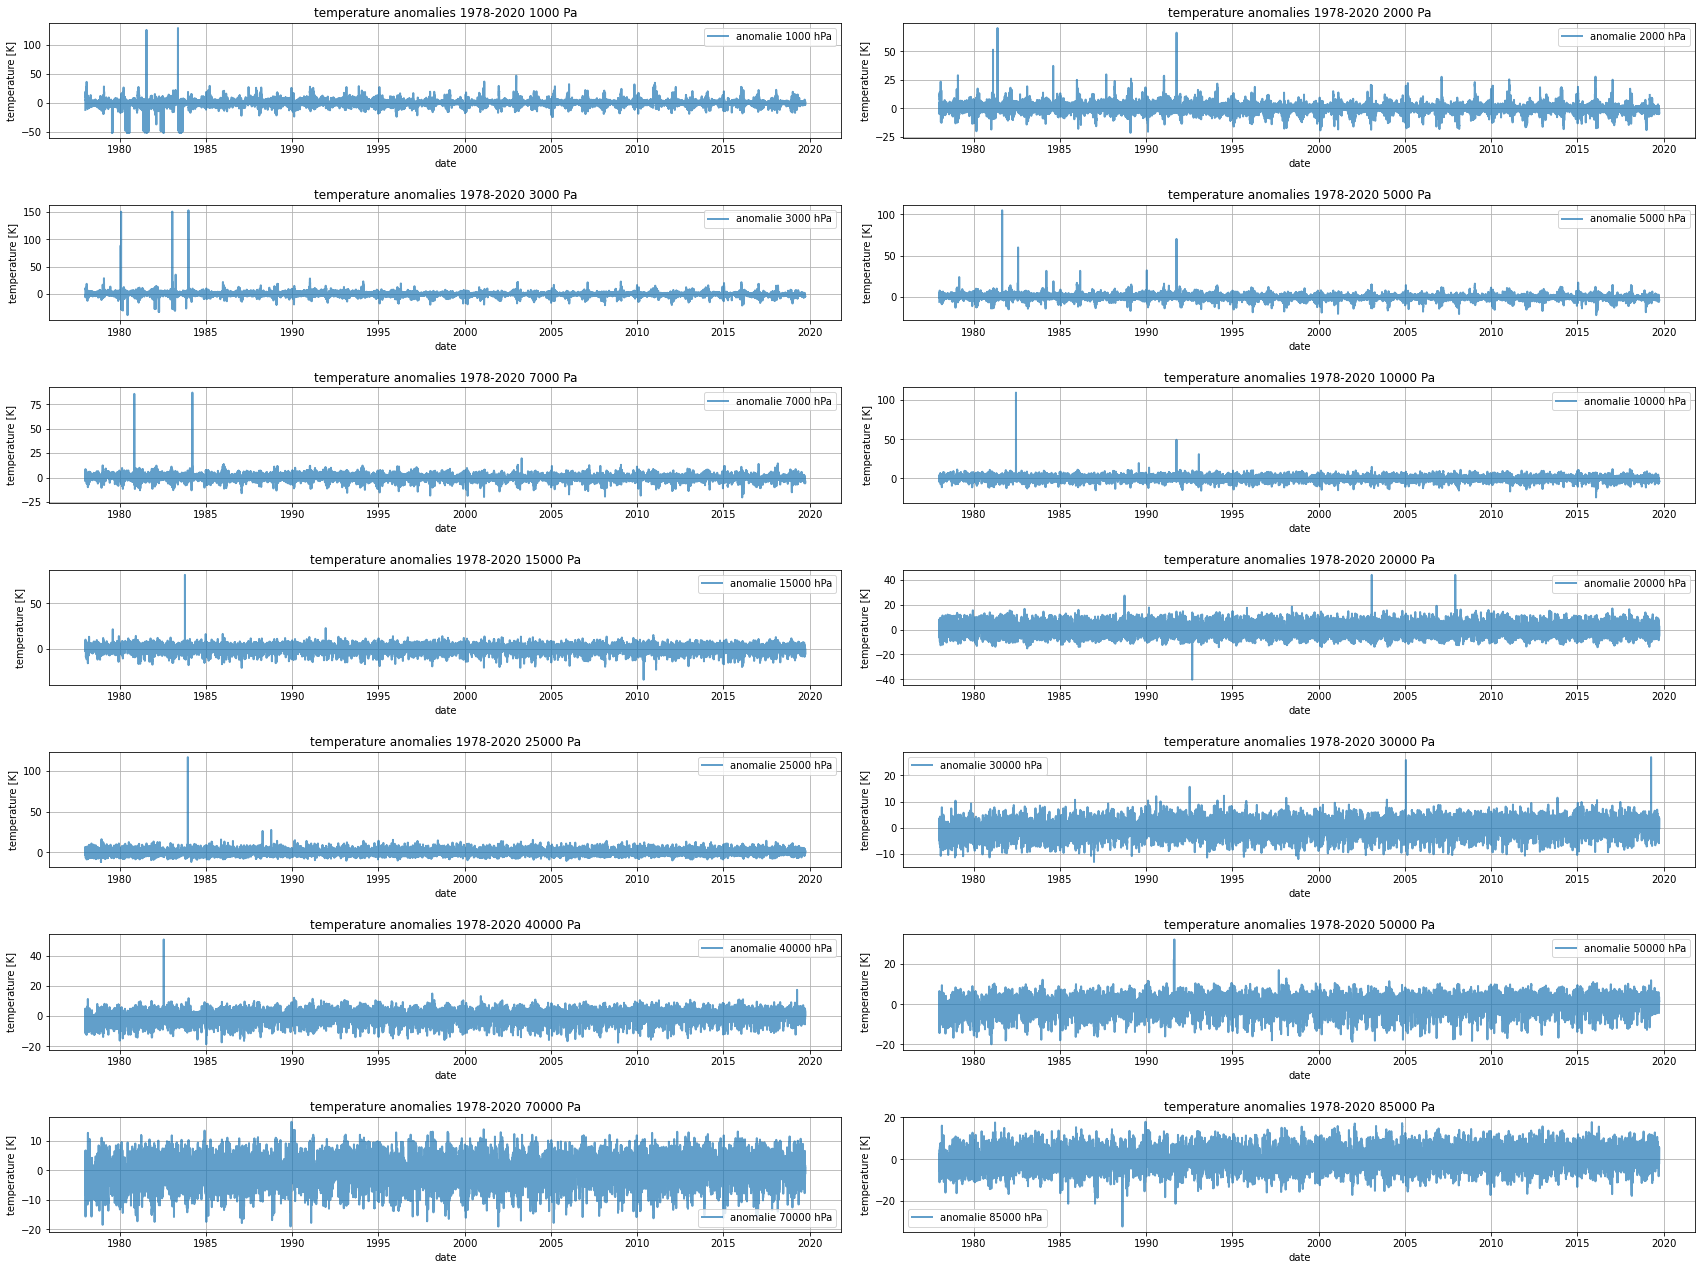

In [61]:
plt.rcParams['figure.figsize'] = [24, 18]
fig, axs = plt.subplots(7, 2)
axs = axs.ravel()
plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]
for i in range(len(plevs)):
    axs[i].grid()
    axs[i].set(xlabel='date', ylabel='temperature [K]', title='temperature anomalies 1978-2020 '+ str(plevs[i])+' Pa')
    axs[i].plot(data[data.z_coordinate == plevs[i]].date_time, anomalies[str(plevs[i])][0], label='anomalie '+str(plevs[i])+' hPa', linewidth=2, alpha=0.7)
    axs[i].legend()
fig.tight_layout(pad=2.0)
plt.show()

## 3) simulation of a request coming from the CDS form by setting as filters a geographic area (defining a bounding box with the latitude and longitude ranges) and a time range on a monthly basis

In [ ]:
plt.rcParams['figure.figsize'] = [24, 18]


fig, axs = plt.subplots(5, 2)
axs = axs.ravel()
for i in range(len(pressdata[0])):
    axs[i].grid()
    axs[i].set(xlabel='date', ylabel='specific humidity [kg/kg]',
       title='Humidity comparison '+ str(pressdata[0][i])+' Pa')
    for j in range(len(name)):
        hum_to_plot = np.array(sh[j])[:,i]
        hum_to_plot[hum_to_plot > np.nanquantile(hum_to_plot, 0.99)] = np.nan
        hum_to_plot[hum_to_plot < np.nanquantile(hum_to_plot, 0.01)] = np.nan
        axs[i].plot(shdates[j], hum_to_plot, label=name[j], linewidth=2, alpha=0.7)

    axs[i].legend()
#     ax2 = axs[i].twinx()
#     ax2.plot(datedata, np.array(tadata)[:,i], color='red', label='adjusted_temperature', linewidth=2, alpha=0.3)
#     ax2.set(xlabel='date', ylabel='temperature [K]')
#     ax2.legend()
fig.tight_layout(pad=2.0)
plt.show()

In [3]:
def ano_plot(calc_data, calc_date, sat_data, sat_date, col, name):
    first = np.array(sat_data)
    first = first[~np.isnan(sat_data)]
    first_date = np.array(sat_date)[~np.isnan(sat_data)]
    second = calc_data[np.isin(calc_date, first_date)]
    first = first[~np.isnan(second)]
    second = second[~np.isnan(second)]
    person_corr_coeff = stats.pearsonr(first, second)

    resi = []
    for i in range(len(calc_data)):
        if calc_date[i] in sat_date:
            resi.append(calc_data[i] - sat_data[sat_date == calc_date[i]])
        else:
            resi.append(np.nan)

    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    ax[0].grid()
    ax[0].set(ylabel='brightness temperature [K]',
       title='anomaly_' + name + ' \n Pearson correlation coefficient '+str(person_corr_coeff[0]))
    ax[0].plot(sat_date, sat_data, color=col, label='sat_' + name, linewidth=4, alpha=0.4)
    ax[0].plot(calc_date, calc_data, color=col, label='rttov_' + name, linewidth=2, alpha=0.8)
    ax[0].legend()
    ax[1].set(xlabel='date', ylabel='brightness temperature [K]')
    ax[1].grid()
    ax[1].plot(calc_date, resi,'--', color=col, label='residual', linewidth=2, alpha=0.8)
    ax[1].legend()
    fig.tight_layout(pad=2.0)
    plt.show()
    return resi

# NOAA 15

## unadjusted

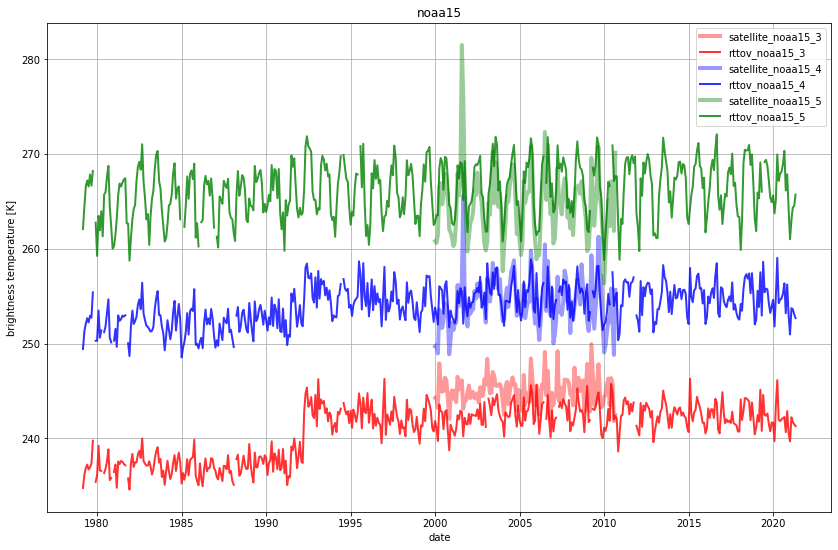

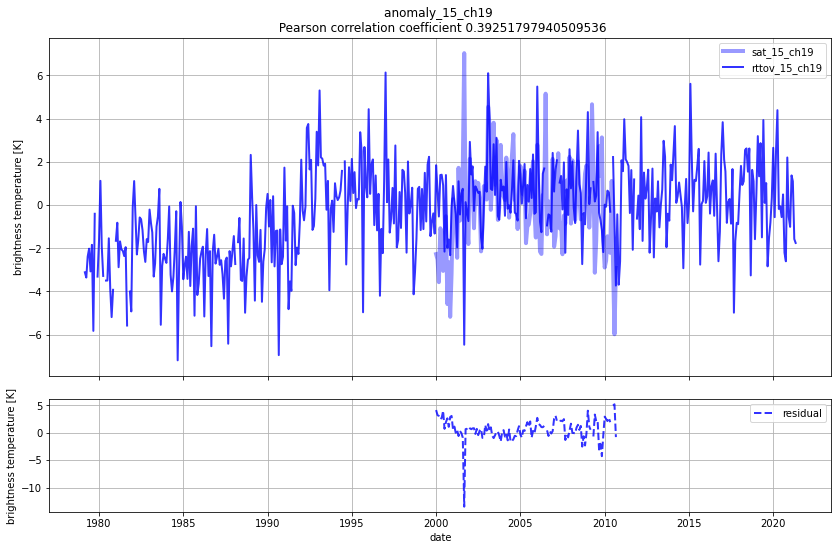

In [7]:
re = pickle.load( open( "./rttov_out_hum_noaa_15_amsub/"+stat+"/"+stat+"_day_refl.p", "rb" ) )
nre = pickle.load( open( "./rttov_out_hum_noaa_15_amsub/"+stat+"/"+stat+"_night_refl.p", "rb" ) )
re = np.nanmean([re, nre], axis=0)
da = pickle.load( open( "./rttov_out_hum_noaa_15_amsub/"+stat+"/"+stat+"_day_dates.p", "rb" ) )
refl = np.resize(re,(len(re),3))
refl_15_18 = refl[:,0]
refl_15_18[refl_15_18 > np.nanquantile(refl_15_18, 0.99)] = np.nan
refl_15_18[refl_15_18 < np.nanquantile(refl_15_18, 0.01)] = np.nan

dates_15_18 = []
for i in range(len(da)):
    dates_15_18.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

refl_15_19 = refl[:,1]
refl_15_19[refl_15_19 > np.nanquantile(refl_15_19, 0.99)] = np.nan
refl_15_19[refl_15_19 < np.nanquantile(refl_15_19, 0.01)] = np.nan
dates_15_19 = dates_15_18

refl_15_20 = refl[:,2]
refl_15_20[refl_15_20 > np.nanquantile(refl_15_20, 0.99)] = np.nan
refl_15_20[refl_15_20 < np.nanquantile(refl_15_20, 0.01)] = np.nan
dates_15_20 = dates_15_18

a = glob.glob('./fiduceo/out/all_noaa15/'+stat+'/*')
a = np.sort(a)
refls_amsub15_18 = []
dates_amsub15_18 = []
refls_amsub15_19 = []
dists_amsub15_19 = []
times_amsub15_19 = []
dates_amsub15_19 = []
refls_amsub15_20 = []
dates_amsub15_20 = []
for i in a[12:]:
    try:
        refs, times, dists = pickle.load( open( i, "rb" ) )
        refls_amsub15_18.append(refs[0])
        refls_amsub15_19.append(refs[1])
        refls_amsub15_20.append(refs[2])
        dists_amsub15_19.append(dists)
        times_amsub15_19.append(times)
    except:
        refls_amsub15_18.append(np.nan)
        refls_amsub15_19.append(np.nan)
        refls_amsub15_20.append(np.nan)
    date = i.split('_')[4:6]
    dates_amsub15_18.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_amsub15_19.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_amsub15_20.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    
ano_refls_amsub15_18, ano_mean_amsub15_18 = calc_anomaly(refls_amsub15_18, dates_amsub15_18)
ano_refls_amsub15_19, ano_mean_amsub15_19 = calc_anomaly(refls_amsub15_19, dates_amsub15_19)
ano_refls_amsub15_20, ano_mean_amsub15_20 = calc_anomaly(refls_amsub15_20, dates_amsub15_20)

ano_refl_15_18, ano_mean_15_18 = calc_anomaly(refl_15_18, dates_15_18, ano_mean_amsub15_18)
ano_refl_15_19, ano_mean_15_19 = calc_anomaly(refl_15_19, dates_15_19, ano_mean_amsub15_19)
ano_refl_15_20, ano_mean_15_20 = calc_anomaly(refl_15_20, dates_15_20, ano_mean_amsub15_20)


bt_plot(calc_datalist = [refl_15_18, refl_15_19, refl_15_20], 
        calc_datelist = [dates_15_18, dates_15_19, dates_15_20],
        sat_datalist = [refls_amsub15_18, refls_amsub15_19, refls_amsub15_20], 
        sat_datelist = [dates_amsub15_18, dates_amsub15_19, dates_amsub15_20],
        name = 'noaa15', chan = 3)

unadj_ano_refl_15_18 = ano_refl_15_18
unadj_dates_15_18 = dates_15_18
unadj_ano_refl_15_19 = ano_refl_15_19
unadj_dates_15_19 = dates_15_19
unadj_ano_refl_15_20 = ano_refl_15_20
unadj_dates_15_20 = dates_15_20

resi_0 = ano_plot(calc_data = np.array(ano_refl_15_18), calc_date = np.array(dates_15_18),
         sat_data = np.array(ano_refls_amsub15_18), sat_date = np.array(dates_amsub15_18),
         col = 'red', name = '15_ch18')
aa = ano_plot(calc_data = np.array(ano_refl_15_19), calc_date = np.array(dates_15_19),
         sat_data = np.array(ano_refls_amsub15_19), sat_date = np.array(dates_amsub15_19),
         col = 'blue', name = '15_ch19')
aa = ano_plot(calc_data = np.array(ano_refl_15_20), calc_date = np.array(dates_15_20),
         sat_data = np.array(ano_refls_amsub15_20), sat_date = np.array(dates_amsub15_20),
         col = 'green', name = '15_ch20')

## adjusted

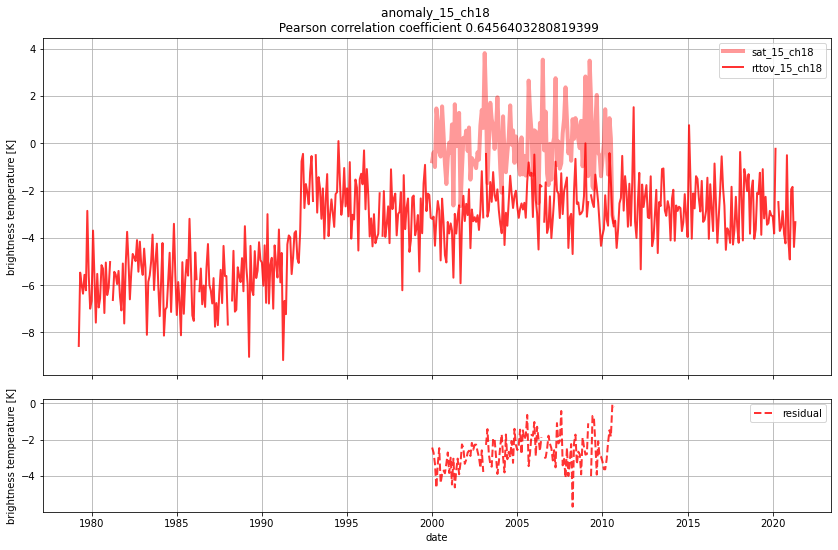

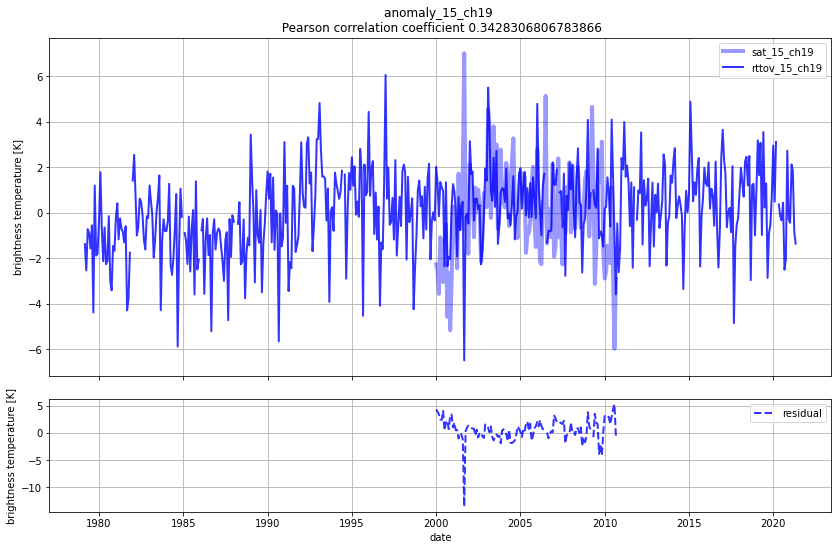

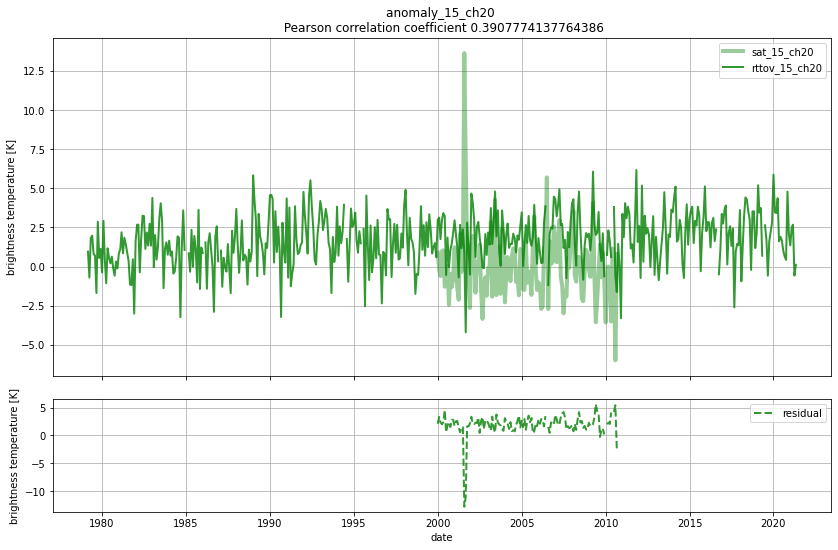

In [8]:
re = pickle.load( open( "./rttov_out_hum_noaa_15_amsub_adj/"+stat+"/"+stat+"_day_refl.p", "rb" ) )
nre = pickle.load( open( "./rttov_out_hum_noaa_15_amsub_adj/"+stat+"/"+stat+"_night_refl.p", "rb" ) )
re = np.nanmean([re, nre], axis=0)
da = pickle.load( open( "./rttov_out_hum_noaa_15_amsub_adj/"+stat+"/"+stat+"_day_dates.p", "rb" ) )
refl = np.resize(re,(len(re),3))
refl_15_18 = refl[:,0]
refl_15_18[refl_15_18 > np.nanquantile(refl_15_18, 0.99)] = np.nan
refl_15_18[refl_15_18 < np.nanquantile(refl_15_18, 0.01)] = np.nan

dates_15_18 = []
for i in range(len(da)):
    dates_15_18.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

refl_15_19 = refl[:,1]
refl_15_19[refl_15_19 > np.nanquantile(refl_15_19, 0.99)] = np.nan
refl_15_19[refl_15_19 < np.nanquantile(refl_15_19, 0.01)] = np.nan
dates_15_19 = dates_15_18

refl_15_20 = refl[:,2]
refl_15_20[refl_15_20 > np.nanquantile(refl_15_20, 0.99)] = np.nan
refl_15_20[refl_15_20 < np.nanquantile(refl_15_20, 0.01)] = np.nan
dates_15_20 = dates_15_18

a = glob.glob('./fiduceo/out/all_noaa15/'+stat+'/*')
a = np.sort(a)
refls_amsub15_18 = []
dates_amsub15_18 = []
refls_amsub15_19 = []
dists_amsub15_19 = []
times_amsub15_19 = []
dates_amsub15_19 = []
refls_amsub15_20 = []
dates_amsub15_20 = []
for i in a[12:]:
    try:
        refs, times, dists = pickle.load( open( i, "rb" ) )
        refls_amsub15_18.append(refs[0])
        refls_amsub15_19.append(refs[1])
        refls_amsub15_20.append(refs[2])
        dists_amsub15_19.append(dists)
        times_amsub15_19.append(times)
    except:
        refls_amsub15_18.append(np.nan)
        refls_amsub15_19.append(np.nan)
        refls_amsub15_20.append(np.nan)
    date = i.split('_')[4:6]
    dates_amsub15_18.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_amsub15_19.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_amsub15_20.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    
ano_refls_amsub15_18, ano_mean_amsub15_18 = calc_anomaly(refls_amsub15_18, dates_amsub15_18)
ano_refls_amsub15_19, ano_mean_amsub15_19 = calc_anomaly(refls_amsub15_19, dates_amsub15_19)
ano_refls_amsub15_20, ano_mean_amsub15_20 = calc_anomaly(refls_amsub15_20, dates_amsub15_20)

ano_refl_15_18, ano_mean_15_18 = calc_anomaly(refl_15_18, dates_15_18, ano_mean_amsub15_18)
ano_refl_15_19, ano_mean_15_19 = calc_anomaly(refl_15_19, dates_15_19, ano_mean_amsub15_19)
ano_refl_15_20, ano_mean_15_20 = calc_anomaly(refl_15_20, dates_15_20, ano_mean_amsub15_20)


bt_plot(calc_datalist = [refl_15_18, refl_15_19, refl_15_20], 
        calc_datelist = [dates_15_18, dates_15_19, dates_15_20],
        sat_datalist = [refls_amsub15_18, refls_amsub15_19, refls_amsub15_20], 
        sat_datelist = [dates_amsub15_18, dates_amsub15_19, dates_amsub15_20],
        name = 'noaa15', chan = 3)


resi_0 = ano_plot(calc_data = np.array(ano_refl_15_18), calc_date = np.array(dates_15_18),
         sat_data = np.array(ano_refls_amsub15_18), sat_date = np.array(dates_amsub15_18),
         col = 'red', name = '15_ch18')
aa = ano_plot(calc_data = np.array(ano_refl_15_19), calc_date = np.array(dates_15_19),
         sat_data = np.array(ano_refls_amsub15_19), sat_date = np.array(dates_amsub15_19),
         col = 'blue', name = '15_ch19')
aa = ano_plot(calc_data = np.array(ano_refl_15_20), calc_date = np.array(dates_15_20),
         sat_data = np.array(ano_refls_amsub15_20), sat_date = np.array(dates_amsub15_20),
         col = 'green', name = '15_ch20')

## comparison

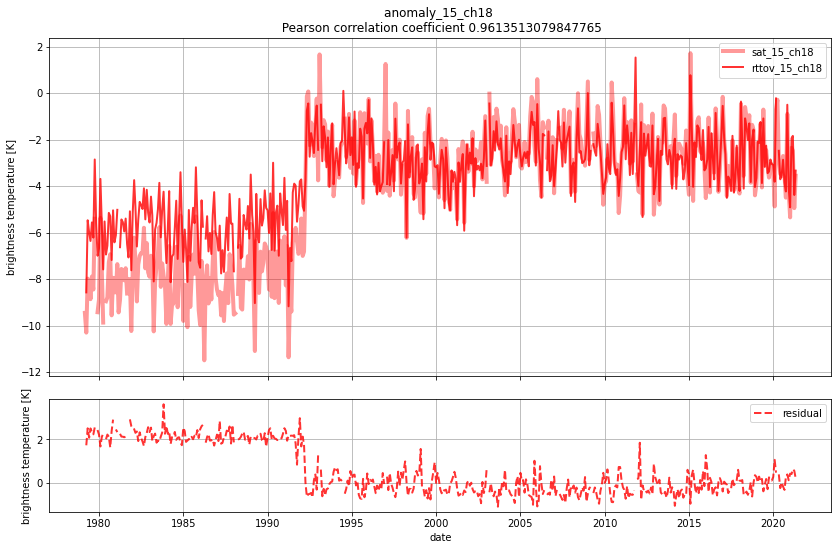

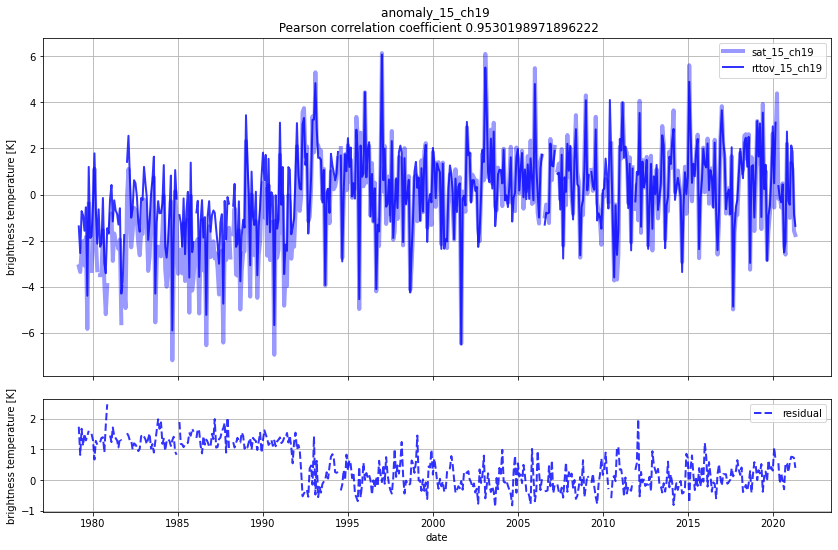

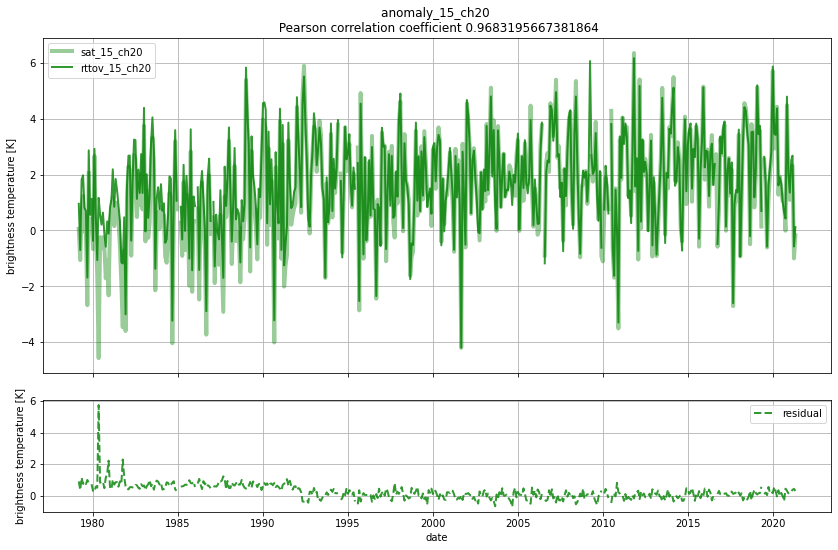

In [9]:
a = ano_plot(calc_data = np.array(ano_refl_15_18), calc_date = np.array(dates_15_18),
         sat_data = np.array(unadj_ano_refl_15_18), sat_date = np.array(unadj_dates_15_18),
         col = 'red', name = '15_ch18')
a = ano_plot(calc_data = np.array(ano_refl_15_19), calc_date = np.array(dates_15_19),
         sat_data = np.array(unadj_ano_refl_15_19), sat_date = np.array(unadj_dates_15_19),
         col = 'blue', name = '15_ch19')
a = ano_plot(calc_data = np.array(ano_refl_15_20), calc_date = np.array(dates_15_20),
         sat_data = np.array(unadj_ano_refl_15_20), sat_date = np.array(unadj_dates_15_20),
         col = 'green', name = '15_ch20')

# NOAA 16

## unadjusted

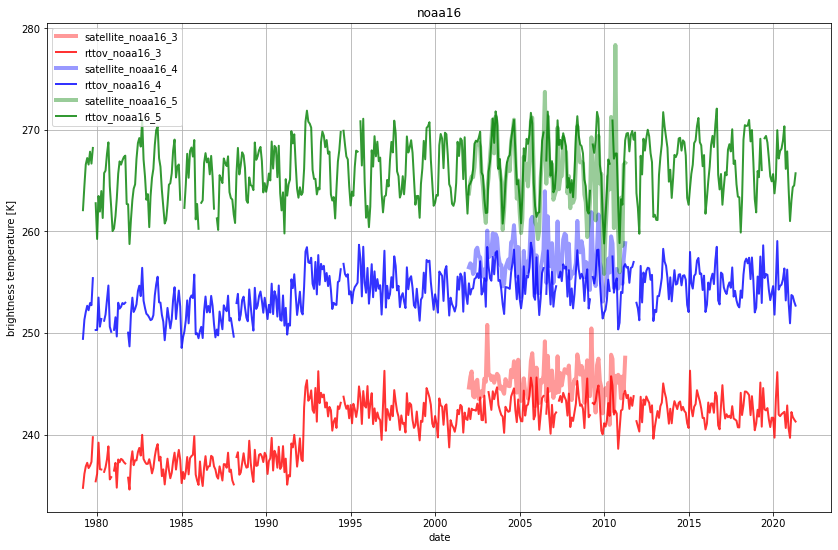

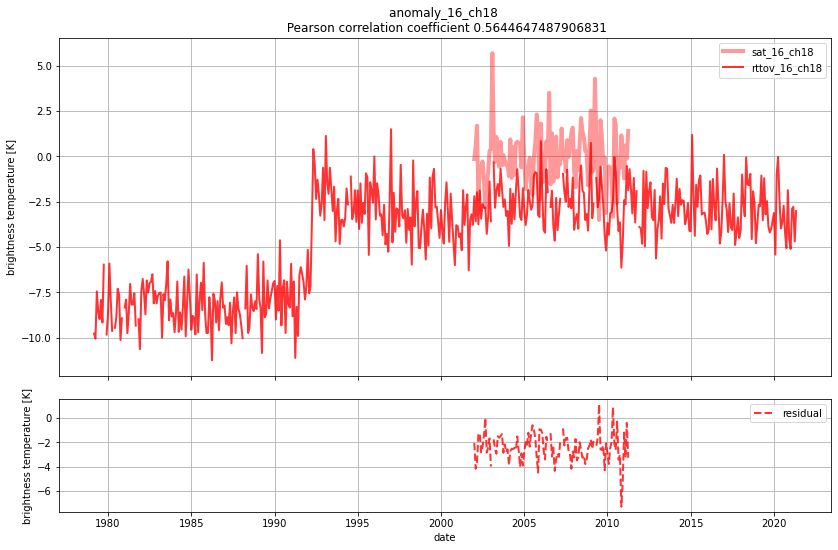

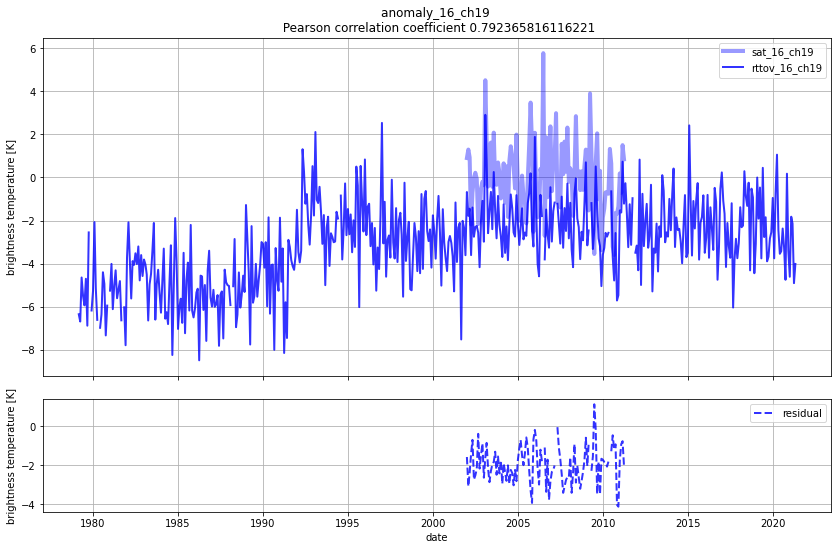

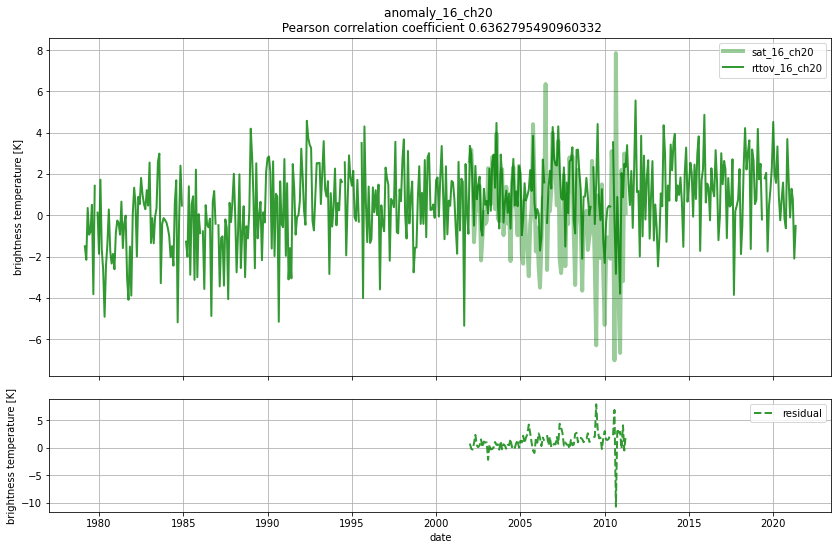

In [10]:
re = pickle.load( open( "./rttov_out_hum_noaa_16_amsub/"+stat+"/"+stat+"_day_refl.p", "rb" ) )
nre = pickle.load( open( "./rttov_out_hum_noaa_16_amsub/"+stat+"/"+stat+"_night_refl.p", "rb" ) )
re = np.nanmean([re, nre], axis=0)
da = pickle.load( open( "./rttov_out_hum_noaa_16_amsub/"+stat+"/"+stat+"_day_dates.p", "rb" ) )
refl = np.resize(re,(len(re),3))
refl_16_18 = refl[:,0]
refl_16_18[refl_16_18 > np.nanquantile(refl_16_18, 0.99)] = np.nan
refl_16_18[refl_16_18 < np.nanquantile(refl_16_18, 0.01)] = np.nan

dates_16_18 = []
for i in range(len(da)):
    dates_16_18.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

refl_16_19 = refl[:,1]
refl_16_19[refl_16_19 > np.nanquantile(refl_16_19, 0.99)] = np.nan
refl_16_19[refl_16_19 < np.nanquantile(refl_16_19, 0.01)] = np.nan

dates_16_19 = dates_16_18

refl_16_20 = refl[:,2]
refl_16_20[refl_16_20 > np.nanquantile(refl_16_20, 0.99)] = np.nan
refl_16_20[refl_16_20 < np.nanquantile(refl_16_20, 0.01)] = np.nan

dates_16_20 = dates_16_18

a = glob.glob('./fiduceo/out/all_noaa16/'+stat+'/*')
a = np.sort(a)
refls_amsub16_18 = []
dates_amsub16_18 = []
refls_amsub16_19 = []
dates_amsub16_19 = []
refls_amsub16_20 = []
dates_amsub16_20 = []
for i in a[12:]:
    try:
        refs, times, dists = pickle.load( open( i, "rb" ) )
        refls_amsub16_18.append(refs[0])
        refls_amsub16_19.append(refs[1])
        refls_amsub16_20.append(refs[2])
    except:
        refls_amsub16_18.append(np.nan)
        refls_amsub16_19.append(np.nan)
        refls_amsub16_20.append(np.nan)
    date = i.split('_')[4:6]
    dates_amsub16_18.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_amsub16_19.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_amsub16_20.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    
ano_refls_amsub16_18, ano_mean_amsub16_18 = calc_anomaly(refls_amsub16_18, dates_amsub16_18)
ano_refls_amsub16_19, ano_mean_amsub16_19 = calc_anomaly(refls_amsub16_19, dates_amsub16_19)
ano_refls_amsub16_20, ano_mean_amsub16_20 = calc_anomaly(refls_amsub16_20, dates_amsub16_20)

ano_refl_16_18, ano_mean_16_18 = calc_anomaly(refl_16_18, dates_16_18, ano_mean_amsub16_18)
ano_refl_16_19, ano_mean_16_19 = calc_anomaly(refl_16_19, dates_16_19, ano_mean_amsub16_19)
ano_refl_16_20, ano_mean_16_20 = calc_anomaly(refl_16_20, dates_16_20, ano_mean_amsub16_20)


bt_plot(calc_datalist = [refl_16_18, refl_16_19, refl_16_20], 
        calc_datelist = [dates_16_18, dates_16_19, dates_16_20],
        sat_datalist = [refls_amsub16_18, refls_amsub16_19, refls_amsub16_20], 
        sat_datelist = [dates_amsub16_18, dates_amsub16_19, dates_amsub16_20],
        name = 'noaa16', chan = 3)

unadj_ano_refl_16_18 = ano_refl_16_18
unadj_dates_16_18 = dates_16_18
unadj_ano_refl_16_19 = ano_refl_16_19
unadj_dates_16_19 = dates_16_19
unadj_ano_refl_16_20 = ano_refl_16_20
unadj_dates_16_20 = dates_16_20

aa = ano_plot(calc_data = np.array(ano_refl_16_18), calc_date = np.array(dates_16_18),
         sat_data = np.array(ano_refls_amsub16_18), sat_date = np.array(dates_amsub16_18),
         col = 'red', name = '16_ch18')
aa = ano_plot(calc_data = np.array(ano_refl_16_19), calc_date = np.array(dates_16_19),
         sat_data = np.array(ano_refls_amsub16_19), sat_date = np.array(dates_amsub16_19),
         col = 'blue', name = '16_ch19')
aa = ano_plot(calc_data = np.array(ano_refl_16_20), calc_date = np.array(dates_16_20),
         sat_data = np.array(ano_refls_amsub16_20), sat_date = np.array(dates_amsub16_20),
         col = 'green', name = '16_ch20')

## adjusted

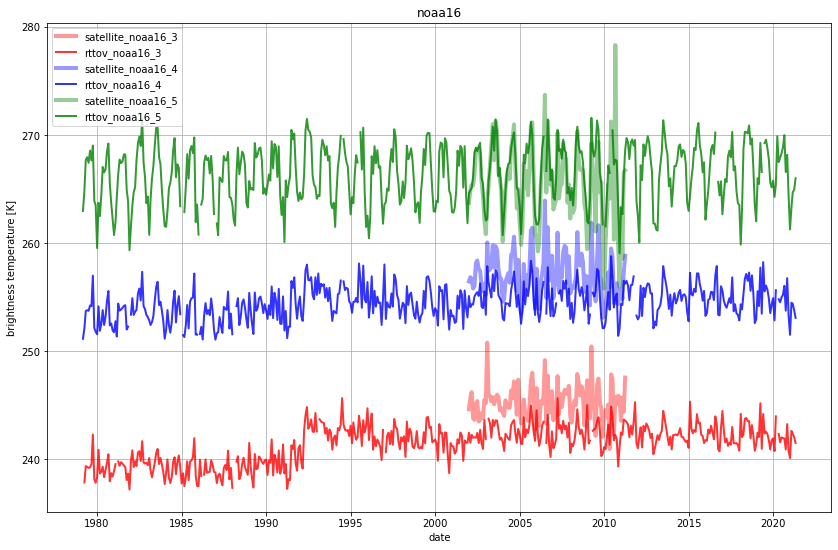

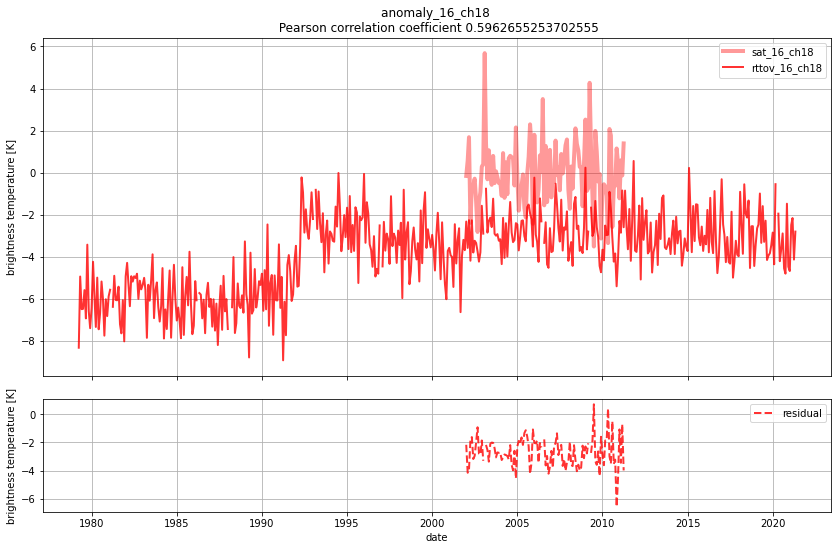

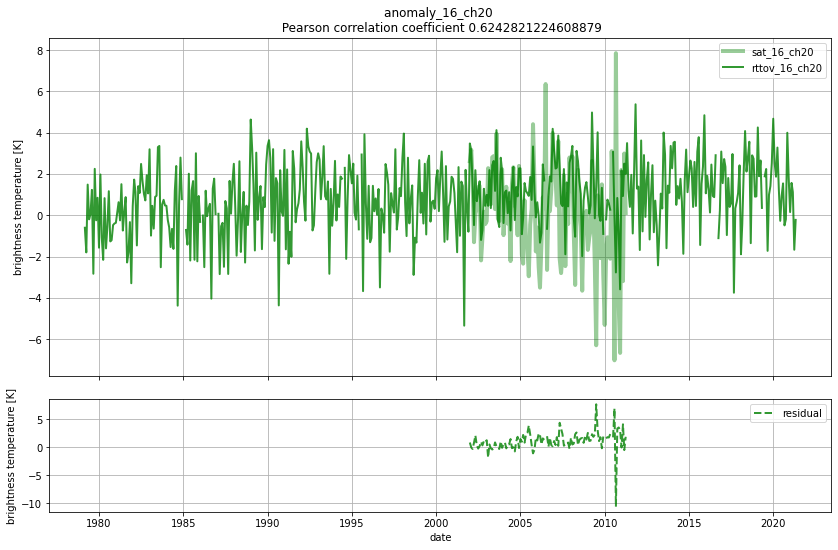

In [11]:
re = pickle.load( open( "./rttov_out_hum_noaa_16_amsub_adj/"+stat+"/"+stat+"_day_refl.p", "rb" ) )
nre = pickle.load( open( "./rttov_out_hum_noaa_16_amsub_adj/"+stat+"/"+stat+"_night_refl.p", "rb" ) )
re = np.nanmean([re, nre], axis=0)
da = pickle.load( open( "./rttov_out_hum_noaa_16_amsub_adj/"+stat+"/"+stat+"_day_dates.p", "rb" ) )
refl = np.resize(re,(len(re),3))
refl_16_18 = refl[:,0]
refl_16_18[refl_16_18 > np.nanquantile(refl_16_18, 0.99)] = np.nan
refl_16_18[refl_16_18 < np.nanquantile(refl_16_18, 0.01)] = np.nan

dates_16_18 = []
for i in range(len(da)):
    dates_16_18.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

refl_16_19 = refl[:,1]
refl_16_19[refl_16_19 > np.nanquantile(refl_16_19, 0.99)] = np.nan
refl_16_19[refl_16_19 < np.nanquantile(refl_16_19, 0.01)] = np.nan

dates_16_19 = dates_16_18

refl_16_20 = refl[:,2]
refl_16_20[refl_16_20 > np.nanquantile(refl_16_20, 0.99)] = np.nan
refl_16_20[refl_16_20 < np.nanquantile(refl_16_20, 0.01)] = np.nan

dates_16_20 = dates_16_18

a = glob.glob('./fiduceo/out/all_noaa16/'+stat+'/*')
a = np.sort(a)
refls_amsub16_18 = []
dates_amsub16_18 = []
refls_amsub16_19 = []
dates_amsub16_19 = []
refls_amsub16_20 = []
dates_amsub16_20 = []
for i in a[12:]:
    try:
        refs, times, dists = pickle.load( open( i, "rb" ) )
        refls_amsub16_18.append(refs[0])
        refls_amsub16_19.append(refs[1])
        refls_amsub16_20.append(refs[2])
    except:
        refls_amsub16_18.append(np.nan)
        refls_amsub16_19.append(np.nan)
        refls_amsub16_20.append(np.nan)
    date = i.split('_')[4:6]
    dates_amsub16_18.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_amsub16_19.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_amsub16_20.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    
ano_refls_amsub16_18, ano_mean_amsub16_18 = calc_anomaly(refls_amsub16_18, dates_amsub16_18)
ano_refls_amsub16_19, ano_mean_amsub16_19 = calc_anomaly(refls_amsub16_19, dates_amsub16_19)
ano_refls_amsub16_20, ano_mean_amsub16_20 = calc_anomaly(refls_amsub16_20, dates_amsub16_20)

ano_refl_16_18, ano_mean_16_18 = calc_anomaly(refl_16_18, dates_16_18, ano_mean_amsub16_18)
ano_refl_16_19, ano_mean_16_19 = calc_anomaly(refl_16_19, dates_16_19, ano_mean_amsub16_19)
ano_refl_16_20, ano_mean_16_20 = calc_anomaly(refl_16_20, dates_16_20, ano_mean_amsub16_20)


bt_plot(calc_datalist = [refl_16_18, refl_16_19, refl_16_20], 
        calc_datelist = [dates_16_18, dates_16_19, dates_16_20],
        sat_datalist = [refls_amsub16_18, refls_amsub16_19, refls_amsub16_20], 
        sat_datelist = [dates_amsub16_18, dates_amsub16_19, dates_amsub16_20],
        name = 'noaa16', chan = 3)

aa = ano_plot(calc_data = np.array(ano_refl_16_18), calc_date = np.array(dates_16_18),
         sat_data = np.array(ano_refls_amsub16_18), sat_date = np.array(dates_amsub16_18),
         col = 'red', name = '16_ch18')
aa = ano_plot(calc_data = np.array(ano_refl_16_19), calc_date = np.array(dates_16_19),
         sat_data = np.array(ano_refls_amsub16_19), sat_date = np.array(dates_amsub16_19),
         col = 'blue', name = '16_ch19')
aa = ano_plot(calc_data = np.array(ano_refl_16_20), calc_date = np.array(dates_16_20),
         sat_data = np.array(ano_refls_amsub16_20), sat_date = np.array(dates_amsub16_20),
         col = 'green', name = '16_ch20')

## comparison

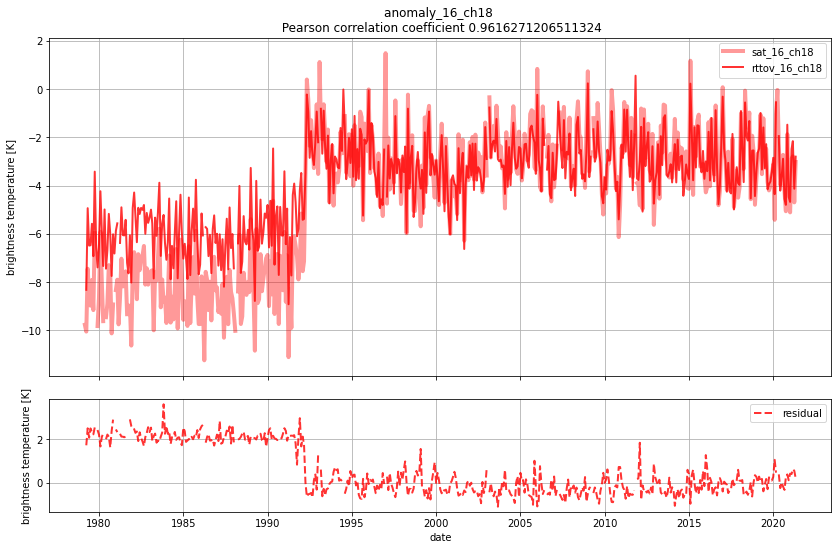

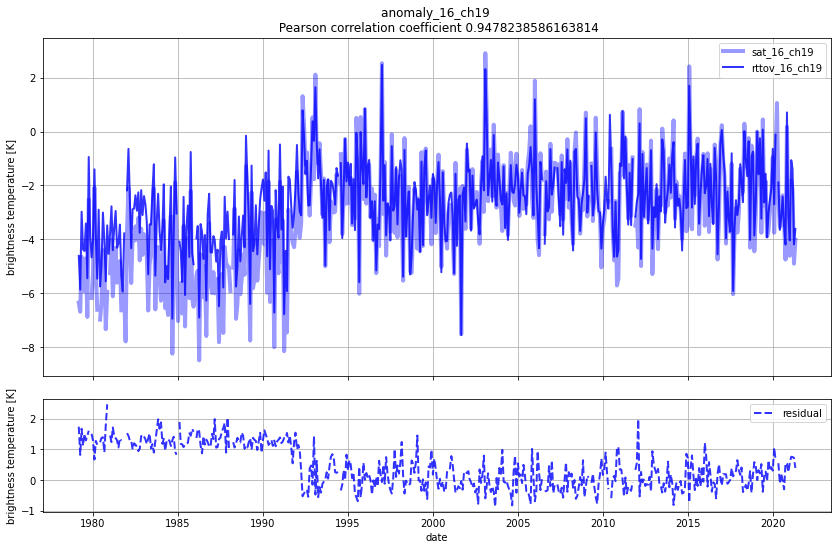

In [12]:
a = ano_plot(calc_data = np.array(ano_refl_16_18), calc_date = np.array(dates_16_18),
         sat_data = np.array(unadj_ano_refl_16_18), sat_date = np.array(unadj_dates_16_18),
         col = 'red', name = '16_ch18')
a = ano_plot(calc_data = np.array(ano_refl_16_19), calc_date = np.array(dates_16_19),
         sat_data = np.array(unadj_ano_refl_16_19), sat_date = np.array(unadj_dates_16_19),
         col = 'blue', name = '16_ch19')
a = ano_plot(calc_data = np.array(ano_refl_16_20), calc_date = np.array(dates_16_20),
         sat_data = np.array(unadj_ano_refl_16_20), sat_date = np.array(unadj_dates_16_20),
         col = 'green', name = '16_ch20')

# NOAA 19

## unadjusted

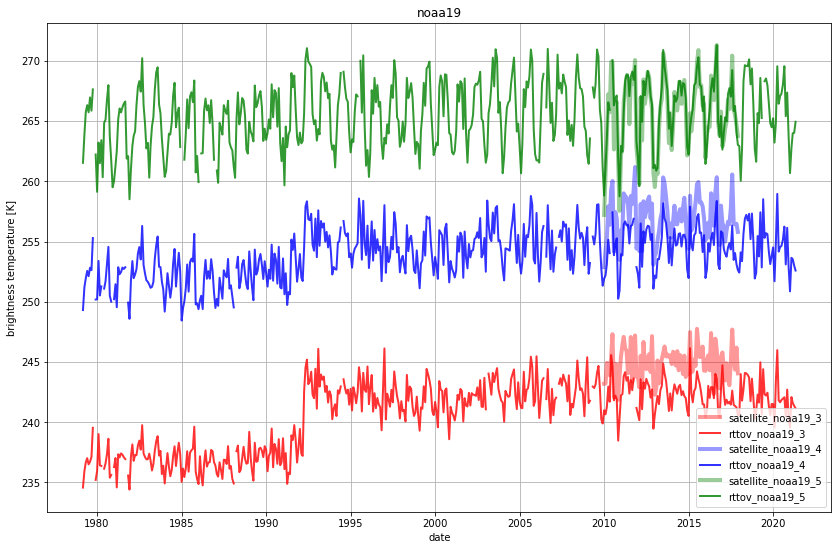

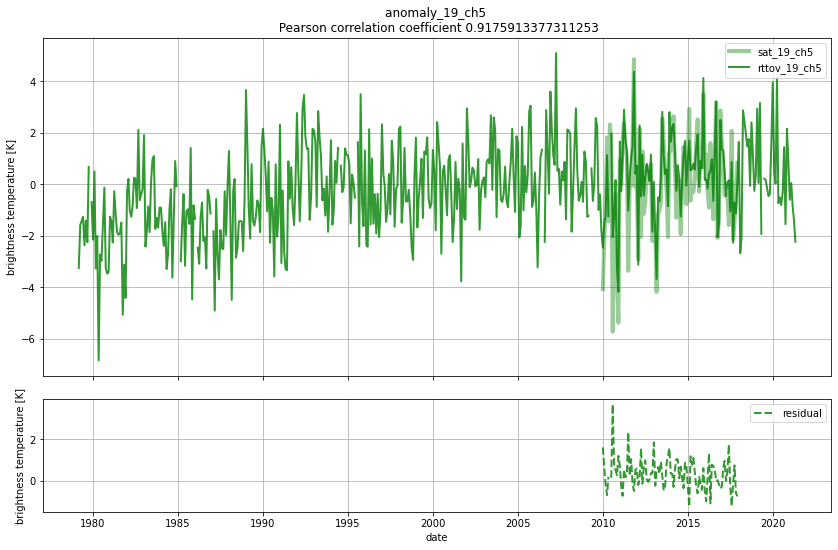

In [13]:
re = pickle.load( open( "./rttov_out_hum_noaa_19_mhs/"+stat+"/"+stat+"_day_refl.p", "rb" ) )
nre = pickle.load( open( "./rttov_out_hum_noaa_19_mhs/"+stat+"/"+stat+"_night_refl.p", "rb" ) )
re = np.nanmean([re, nre], axis=0)
da = pickle.load( open( "./rttov_out_hum_noaa_19_mhs/"+stat+"/"+stat+"_day_dates.p", "rb" ) )
refl = np.resize(re,(len(re),3))
refl_19_3 = refl[:,0]
refl_19_3[refl_19_3 > np.nanquantile(refl_19_3, 0.99)] = np.nan
refl_19_3[refl_19_3 < np.nanquantile(refl_19_3, 0.01)] = np.nan
dates_19_3 = []
for i in range(len(da)):
    dates_19_3.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

refl_19_4 = refl[:,1]
refl_19_4[refl_19_4 > np.nanquantile(refl_19_4, 0.99)] = np.nan
refl_19_4[refl_19_4 < np.nanquantile(refl_19_4, 0.01)] = np.nan
dates_19_4 = dates_19_3

refl_19_5 = refl[:,2]
refl_19_5[refl_19_5 > np.nanquantile(refl_19_5, 0.99)] = np.nan
refl_19_5[refl_19_5 < np.nanquantile(refl_19_5, 0.01)] = np.nan
dates_19_5 = dates_19_3

a = glob.glob('./fiduceo/out/all_noaa19/'+stat+'/*')
a = np.sort(a)
refls_mhs19_3 = []
dates_mhs19_3 = []
refls_mhs19_4 = []
dates_mhs19_4 = []
refls_mhs19_5 = []
dates_mhs19_5 = []
for i in a[12:]:
    try:
        refs, times, dists = pickle.load( open( i, "rb" ) )
        refls_mhs19_3.append(refs[0])
        refls_mhs19_4.append(refs[1])
        refls_mhs19_5.append(refs[2])
    except:
        refls_mhs19_3.append(np.nan)
        refls_mhs19_4.append(np.nan)
        refls_mhs19_5.append(np.nan)
    date = i.split('_')[4:6]
    dates_mhs19_3.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_mhs19_4.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_mhs19_5.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))

ano_refls_mhs19_3, ano_mean_mhs19_3 = calc_anomaly(refls_mhs19_3, dates_mhs19_3)
ano_refls_mhs19_4, ano_mean_mhs19_4 = calc_anomaly(refls_mhs19_4, dates_mhs19_4)
ano_refls_mhs19_5, ano_mean_mhs19_5 = calc_anomaly(refls_mhs19_5, dates_mhs19_5)

ano_refl_19_3, ano_mean_19_3 = calc_anomaly(refl_19_3, dates_19_3, ano_mean_mhs19_3)
ano_refl_19_4, ano_mean_19_4 = calc_anomaly(refl_19_4, dates_19_4, ano_mean_mhs19_4)
ano_refl_19_5, ano_mean_19_5 = calc_anomaly(refl_19_5, dates_19_5, ano_mean_mhs19_5) 
    
bt_plot(calc_datalist = [refl_19_3, refl_19_4, refl_19_5], 
        calc_datelist = [dates_19_3, dates_19_4, dates_19_5],
        sat_datalist = [refls_mhs19_3, refls_mhs19_4, refls_mhs19_5], 
        sat_datelist = [dates_mhs19_3, dates_mhs19_4, dates_mhs19_5],
        name = 'noaa19', chan = 3)

unadj_ano_refl_19_3 = ano_refl_19_3
unadj_dates_19_3 = dates_19_3
unadj_ano_refl_19_4 = ano_refl_19_4
unadj_dates_19_4 = dates_19_4
unadj_ano_refl_19_5 = ano_refl_19_5
unadj_dates_19_5 = dates_19_5

aa = ano_plot(calc_data = np.array(ano_refl_19_3), calc_date = np.array(dates_19_3),
         sat_data = np.array(ano_refls_mhs19_3), sat_date = np.array(dates_mhs19_3),
         col = 'red', name = '19_ch3')
aa = ano_plot(calc_data = np.array(ano_refl_19_4), calc_date = np.array(dates_19_4),
         sat_data = np.array(ano_refls_mhs19_4), sat_date = np.array(dates_mhs19_4),
         col = 'blue', name = '19_ch4')
aa = ano_plot(calc_data = np.array(ano_refl_19_5), calc_date = np.array(dates_19_5),
         sat_data = np.array(ano_refls_mhs19_5), sat_date = np.array(dates_mhs19_5),
         col = 'green', name = '19_ch5')

## adjusted

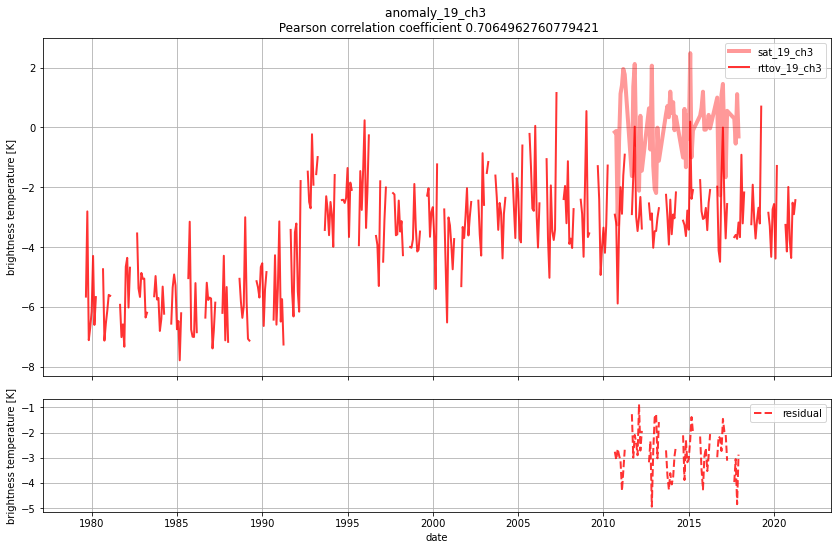

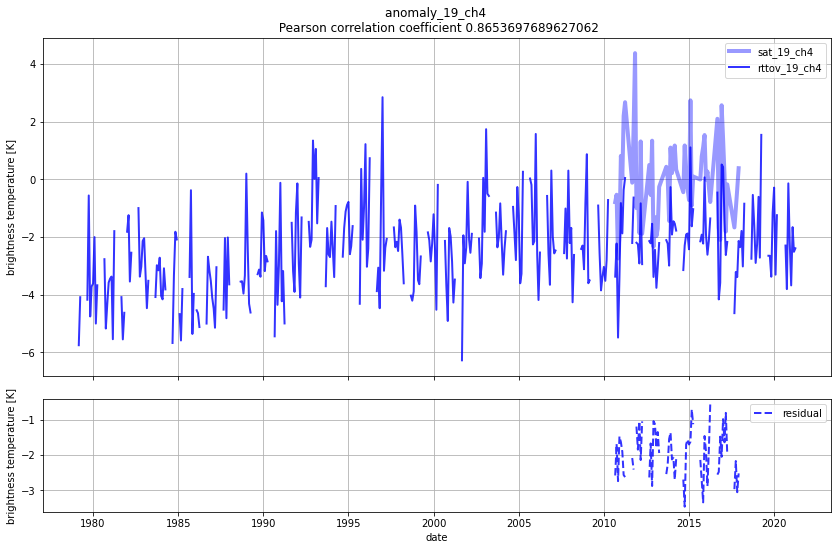

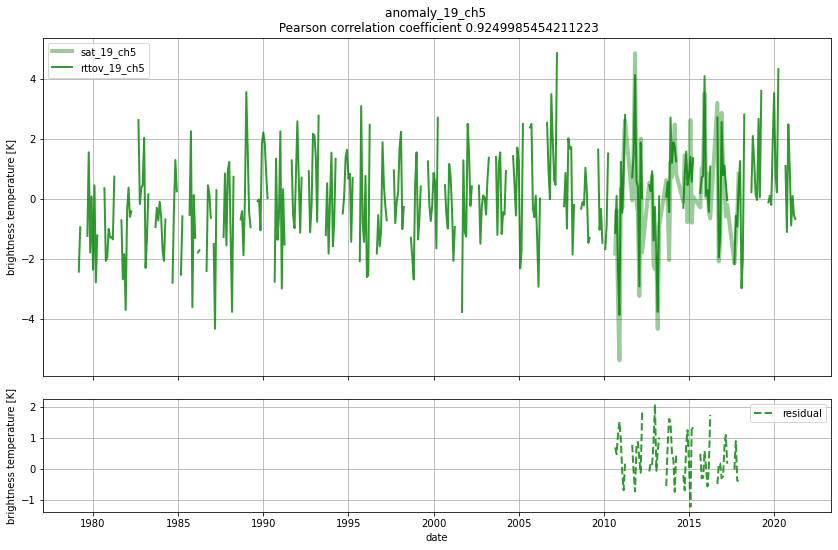

In [14]:
re = pickle.load( open( "./rttov_out_hum_noaa_19_mhs_adj/"+stat+"/"+stat+"_day_refl.p", "rb" ) )
nre = pickle.load( open( "./rttov_out_hum_noaa_19_mhs_adj/"+stat+"/"+stat+"_night_refl.p", "rb" ) )
re = np.nanmean([re, nre], axis=0)
da = pickle.load( open( "./rttov_out_hum_noaa_19_mhs_adj/"+stat+"/"+stat+"_day_dates.p", "rb" ) )

refl = np.resize(re,(len(re),3))
refl_19_3 = refl[:,0]
refl_19_3[refl_19_3 > np.nanquantile(refl_19_3, 0.99)] = np.nan
refl_19_3[refl_19_3 < np.nanquantile(refl_19_3, 0.01)] = np.nan
dates_19_3 = []
for i in range(len(da)):
    dates_19_3.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

refl_19_4 = refl[:,1]
refl_19_4[refl_19_4 > np.nanquantile(refl_19_4, 0.99)] = np.nan
refl_19_4[refl_19_4 < np.nanquantile(refl_19_4, 0.01)] = np.nan
dates_19_4 = dates_19_3

refl_19_5 = refl[:,2]
refl_19_5[refl_19_5 > np.nanquantile(refl_19_5, 0.99)] = np.nan
refl_19_5[refl_19_5 < np.nanquantile(refl_19_5, 0.01)] = np.nan
dates_19_5 = dates_19_3

flist = glob.glob('./fiduceo/out/all_noaa19/'+stat+'/*')
a = []
for i in flist:
    if i.split('_')[5] in ['01','02','03','04','09','10','11','12']:
        a.append(i)
a = np.sort(a)

refls_mhs19_3 = []
dates_mhs19_3 = []
refls_mhs19_4 = []
dates_mhs19_4 = []
refls_mhs19_5 = []
dates_mhs19_5 = []
for i in a[12:]:
    try:
        refs, times, dists = pickle.load( open( i, "rb" ) )
        refls_mhs19_3.append(refs[0])
        refls_mhs19_4.append(refs[1])
        refls_mhs19_5.append(refs[2])
    except:
        refls_mhs19_3.append(np.nan)
        refls_mhs19_4.append(np.nan)
        refls_mhs19_5.append(np.nan)
    date = i.split('_')[4:6]
    dates_mhs19_3.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_mhs19_4.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_mhs19_5.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))

ano_refls_mhs19_3, ano_mean_mhs19_3 = calc_anomaly(refls_mhs19_3, dates_mhs19_3)
ano_refls_mhs19_4, ano_mean_mhs19_4 = calc_anomaly(refls_mhs19_4, dates_mhs19_4)
ano_refls_mhs19_5, ano_mean_mhs19_5 = calc_anomaly(refls_mhs19_5, dates_mhs19_5)

ano_refl_19_3, ano_mean_19_3 = calc_anomaly(refl_19_3, dates_19_3, ano_mean_mhs19_3)
ano_refl_19_4, ano_mean_19_4 = calc_anomaly(refl_19_4, dates_19_4, ano_mean_mhs19_4)
ano_refl_19_5, ano_mean_19_5 = calc_anomaly(refl_19_5, dates_19_5, ano_mean_mhs19_5) 
    
bt_plot(calc_datalist = [refl_19_3, refl_19_4, refl_19_5], 
        calc_datelist = [dates_19_3, dates_19_4, dates_19_5],
        sat_datalist = [refls_mhs19_3, refls_mhs19_4, refls_mhs19_5], 
        sat_datelist = [dates_mhs19_3, dates_mhs19_4, dates_mhs19_5],
        name = 'noaa19', chan = 3)

aa = ano_plot(calc_data = np.array(ano_refl_19_3), calc_date = np.array(dates_19_3),
         sat_data = np.array(ano_refls_mhs19_3), sat_date = np.array(dates_mhs19_3),
         col = 'red', name = '19_ch3')
aa = ano_plot(calc_data = np.array(ano_refl_19_4), calc_date = np.array(dates_19_4),
         sat_data = np.array(ano_refls_mhs19_4), sat_date = np.array(dates_mhs19_4),
         col = 'blue', name = '19_ch4')
aa = ano_plot(calc_data = np.array(ano_refl_19_5), calc_date = np.array(dates_19_5),
         sat_data = np.array(ano_refls_mhs19_5), sat_date = np.array(dates_mhs19_5),
         col = 'green', name = '19_ch5')

## comparison

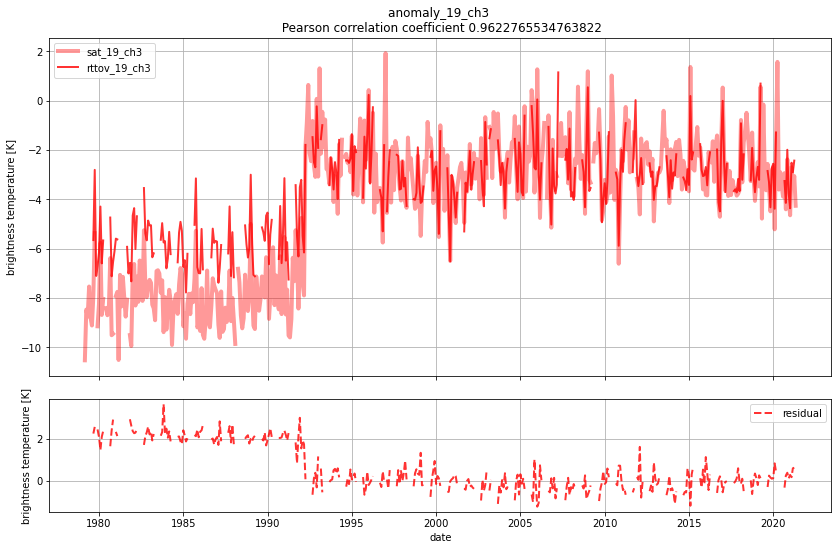

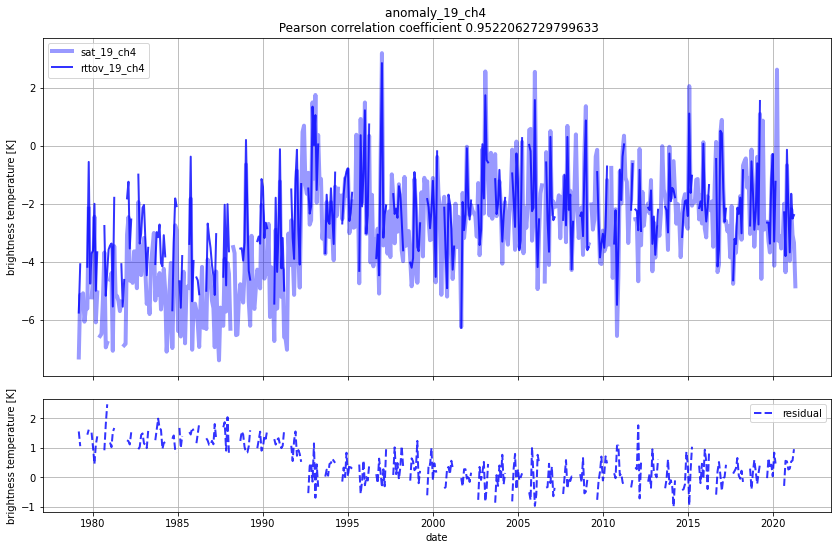

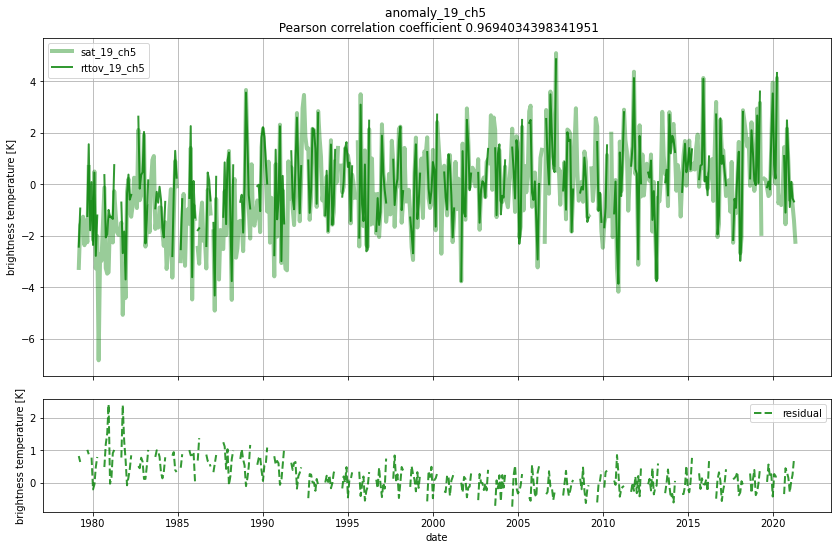

In [15]:
a = ano_plot(calc_data = np.array(ano_refl_19_3), calc_date = np.array(dates_19_3),
         sat_data = np.array(unadj_ano_refl_19_3), sat_date = np.array(unadj_dates_19_3),
         col = 'red', name = '19_ch3')
a = ano_plot(calc_data = np.array(ano_refl_19_4), calc_date = np.array(dates_19_4),
         sat_data = np.array(unadj_ano_refl_19_4), sat_date = np.array(unadj_dates_19_4),
         col = 'blue', name = '19_ch4')
a = ano_plot(calc_data = np.array(ano_refl_19_5), calc_date = np.array(dates_19_5),
         sat_data = np.array(unadj_ano_refl_19_5), sat_date = np.array(unadj_dates_19_5),
         col = 'green', name = '19_ch5')

---
---

In [16]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='sat_brightness_temperatures_ch18/3')
ax.plot(dates_amsub15_18, refls_amsub15_18, color='red', label='amsub_15_ch18', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_18, refls_amsub16_18, color='grey', label='amsub_16_ch18', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_3, refls_mhs19_3, color='black', label='mhs_19_ch3', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

In [17]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_sat_brightness_temperatures_ch18/3')
ax.plot(dates_amsub15_18, ano_refls_amsub15_18, color='red', label='amsub_15_ch18', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_18, ano_refls_amsub16_18, color='grey', label='amsub_16_ch18', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_3, ano_refls_mhs19_3, color='black', label='mhs_19_ch3', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

In [18]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='sat_brightness_temperatures_ch19/4')

ax.plot(dates_amsub15_19, refls_amsub15_19, color='blue', label='amsub_15_ch19', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_19, refls_amsub16_19, color='grey', label='amsub_16_ch19', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_4, refls_mhs19_4, color='black', label='mhs_19_ch4', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

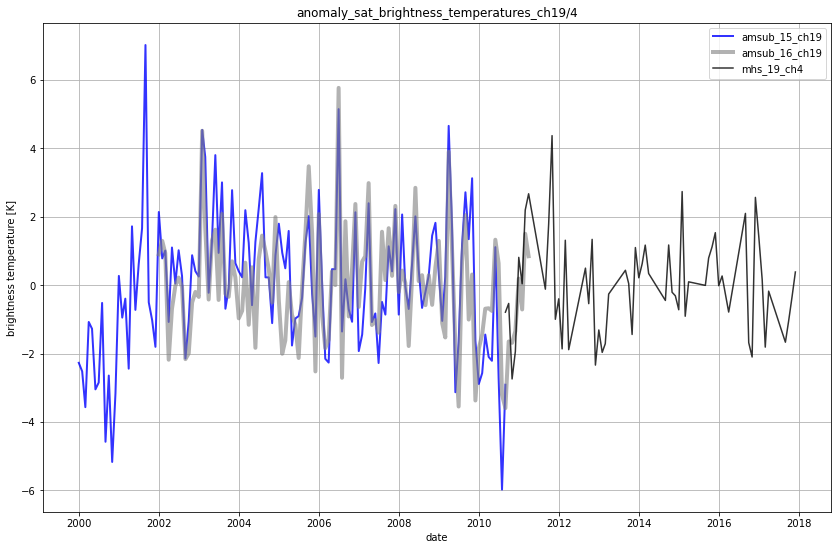

In [19]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_sat_brightness_temperatures_ch19/4')

ax.plot(dates_amsub15_19, ano_refls_amsub15_19, color='blue', label='amsub_15_ch19', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_19, ano_refls_amsub16_19, color='grey', label='amsub_16_ch19', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_4, ano_refls_mhs19_4, color='black', label='mhs_19_ch4', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

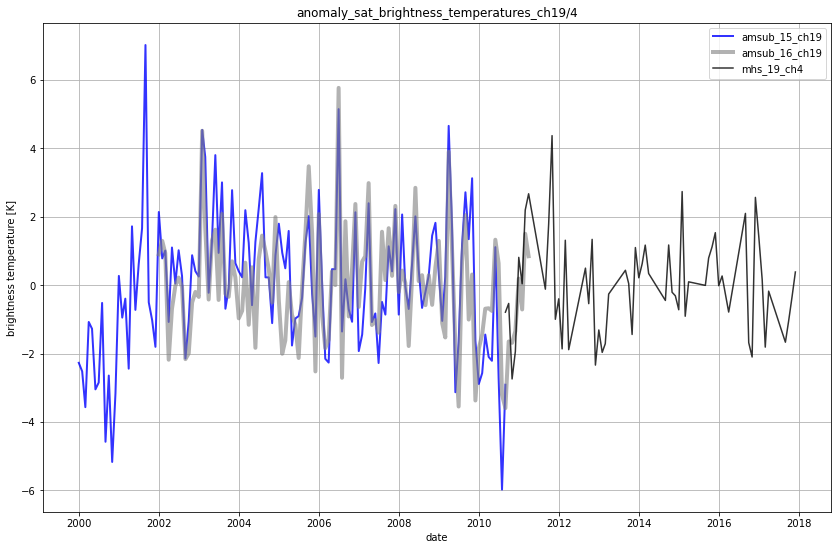

In [20]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_sat_brightness_temperatures_ch19/4')

ax.plot(dates_amsub15_19, ano_refls_amsub15_19, color='blue', label='amsub_15_ch19', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_19, ano_refls_amsub16_19, color='grey', label='amsub_16_ch19', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_4, ano_refls_mhs19_4, color='black', label='mhs_19_ch4', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

In [21]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='sat_brightness_temperatures_ch20/5')

ax.plot(dates_amsub15_20, refls_amsub15_20, color='green', label='amsub_15_ch20', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_20, refls_amsub16_20, color='grey', label='amsub_16_ch20', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_5, refls_mhs19_5, color='black', label='mhs_19_ch5', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

In [22]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_sat_brightness_temperatures_ch20/5')

ax.plot(dates_amsub15_20, ano_refls_amsub15_20, color='green', label='amsub_15_ch20', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_20, ano_refls_amsub16_20, color='grey', label='amsub_16_ch20', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_5, ano_refls_mhs19_5, color='black', label='mhs_19_ch5', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

## RTTOV Comparison

In [23]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='RTTOV_ch18/3')

ax.plot(dates_15_18, refl_15_18, color='red', label='amsub_15_ch18', linewidth=2, alpha=1)
ax.plot(dates_16_18, refl_16_18, color='grey', label='amsub_16_ch18', linewidth=6, alpha=0.6)
ax.plot(dates_19_3, refl_19_3, color='black', label='mhs_19_ch3', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

In [24]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_RTTOV_ch18/3')

ax.plot(dates_15_18, ano_refl_15_18, color='red', label='amsub_15_ch18', linewidth=2, alpha=1)
ax.plot(dates_16_18, ano_refl_16_18, color='grey', label='amsub_16_ch18', linewidth=6, alpha=0.6)
ax.plot(dates_19_3, ano_refl_19_3, color='black', label='mhs_19_ch3', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

In [25]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='RTTOV_ch19/4')

ax.plot(dates_15_19, refl_15_19, color='blue', label='amsub_15_ch18', linewidth=2, alpha=1)
ax.plot(dates_16_19, refl_16_19, color='grey', label='amsub_16_ch18', linewidth=6, alpha=0.6)
ax.plot(dates_19_4, refl_19_4, color='black', label='mhs_19_ch4', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

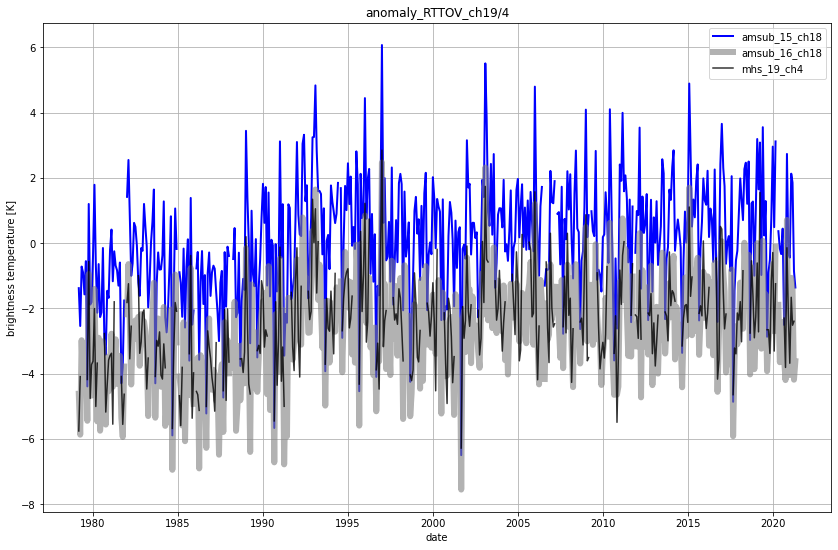

In [26]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_RTTOV_ch19/4')

ax.plot(dates_15_19, ano_refl_15_19, color='blue', label='amsub_15_ch18', linewidth=2, alpha=1)
ax.plot(dates_16_19, ano_refl_16_19, color='grey', label='amsub_16_ch18', linewidth=6, alpha=0.6)
ax.plot(dates_19_4, ano_refl_19_4, color='black', label='mhs_19_ch4', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

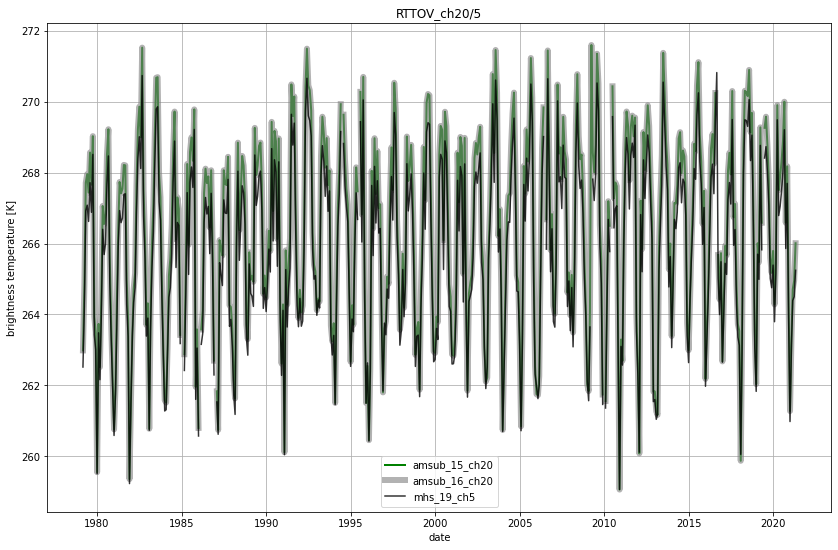

In [27]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='RTTOV_ch20/5')

ax.plot(dates_15_20, refl_15_20, color='green', label='amsub_15_ch20', linewidth=2, alpha=1)
ax.plot(dates_16_20, refl_16_20, color='grey', label='amsub_16_ch20', linewidth=6, alpha=0.6)
ax.plot(dates_19_5, refl_19_5, color='black', label='mhs_19_ch5', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

In [28]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_RTTOV_ch20/5')

ax.plot(dates_15_20, ano_refl_15_20, color='green', label='amsub_15_ch20', linewidth=2, alpha=1)
ax.plot(dates_16_20, ano_refl_16_20, color='grey', label='amsub_16_ch20', linewidth=6, alpha=0.6)
ax.plot(dates_19_5, ano_refl_19_5, color='black', label='mhs_19_ch5', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()